# Forecasting Walmart Sales

In [1]:
# Import libraries

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller # ADF test for stationarity
from tqdm import tqdm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

## Import Train Data

In [2]:
train_df = pd.read_csv('Data/train.csv')
train_df.rename(columns={'Sales(In ThousandDollars)': 'Sales'}, inplace=True)
train_df

,Year,Month,ProductCategory,Sales
0,2009,1,WomenClothing,1755.0
1,2009,1,MenClothing,524.0
2,2009,1,OtherClothing,936.0
3,2009,2,WomenClothing,1729.0
4,2009,2,MenClothing,496.0
...,...,...,...,...
175,2013,11,MenClothing,798.0
176,2013,11,OtherClothing,1209.0
177,2013,12,WomenClothing,4865.0
178,2013,12,MenClothing,1085.0


Create a date field to support EDA

In [3]:
# Combine year and month into a datetime column representing the end of the month

train_df['Date'] = pd.to_datetime(train_df[['Year', 'Month']].assign(day=1)) + pd.offsets.MonthEnd(1)

In [4]:
train_df.describe(include='all')

,Year,Month,ProductCategory,Sales,Date
count,180.000000,180.000000,180,170.000000,180
unique,NaN,NaN,3,NaN,NaN
top,NaN,NaN,WomenClothing,NaN,NaN
freq,NaN,NaN,60,NaN,NaN
mean,2011.000000,6.500000,NaN,1616.729412,2011-07-16 07:12:00
min,2009.000000,1.000000,NaN,471.000000,2009-01-31 00:00:00
25%,2010.000000,3.750000,NaN,704.000000,2010-04-22 12:00:00
50%,2011.000000,6.500000,NaN,1041.000000,2011-07-15 12:00:00
75%,2012.000000,9.250000,NaN,2609.750000,2012-10-07 18:00:00
max,2013.000000,12.000000,NaN,4865.000000,2013-12-31 00:00:00


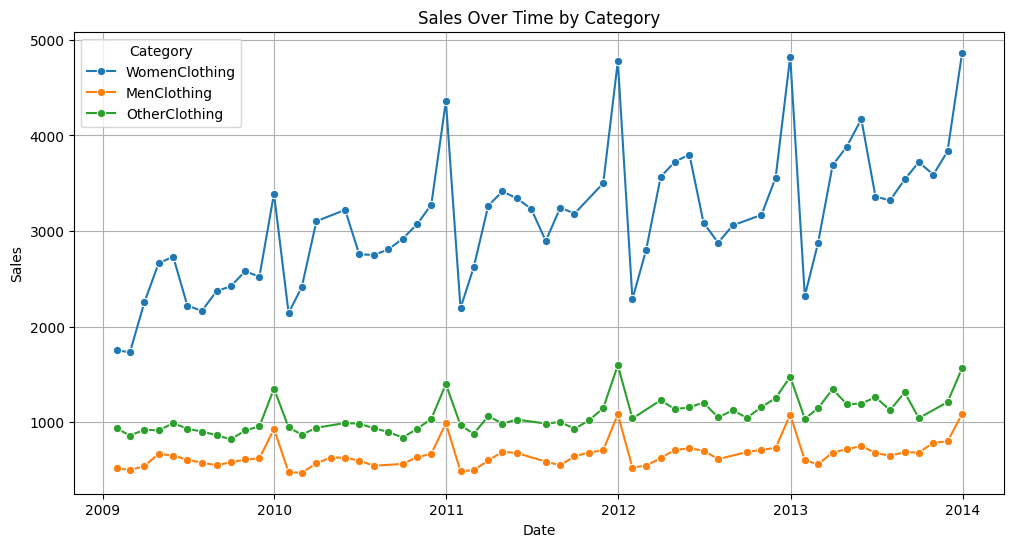

In [5]:
# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=train_df, x='Date', y='Sales', hue='ProductCategory', marker='o')

plt.title('Sales Over Time by Category')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend(title='Category')
plt.grid(True)
plt.show()

**Notes from the Plot:**

1. **Sales Trends by Category:**

    WomenClothing: This category shows a significant upward trend over time with notable peaks around the end of each year, indicating a seasonal pattern. Sales generally increase towards the end of each year, likely due to holiday shopping.
    MenClothing: This category shows a relatively stable trend with slight fluctuations. There are small peaks around the end of each year, but the overall sales are much lower than WomenClothing.
    OtherClothing: This category also shows a stable trend similar to MenClothing, with occasional spikes towards the end of each year.

2. **Sales Magnitude:**

    WomenClothing consistently has the highest sales compared to the other two categories. The sales values for WomenClothing range between 2000 and 5000.
    MenClothing and OtherClothing have lower sales values, mostly under 1000, with MenClothing slightly lower than OtherClothing.

3. **Seasonal Peaks:**

    All categories show spikes around the end of each year. This suggests that there might be seasonal events, such as holidays, that drive up sales during these periods.

## SARIMA Model

* The Seasonal ARIMA model is a univariate model focused on analyzing and forecasting a single time series, meaning that it can't take any additional inpdependent variables
* The ARIMA model can't handle missing values, data preprocessing is required 
* The ARIMA model requires stationary time series, meaning that the statistical properties of the time series, such as the mean, variance, and autocorrelation, remain constant over time

### Data Preprocessing

In [6]:
# Create a copy of the training dataframe

train_arima_df = train_df.copy()

#### Split the data by product category

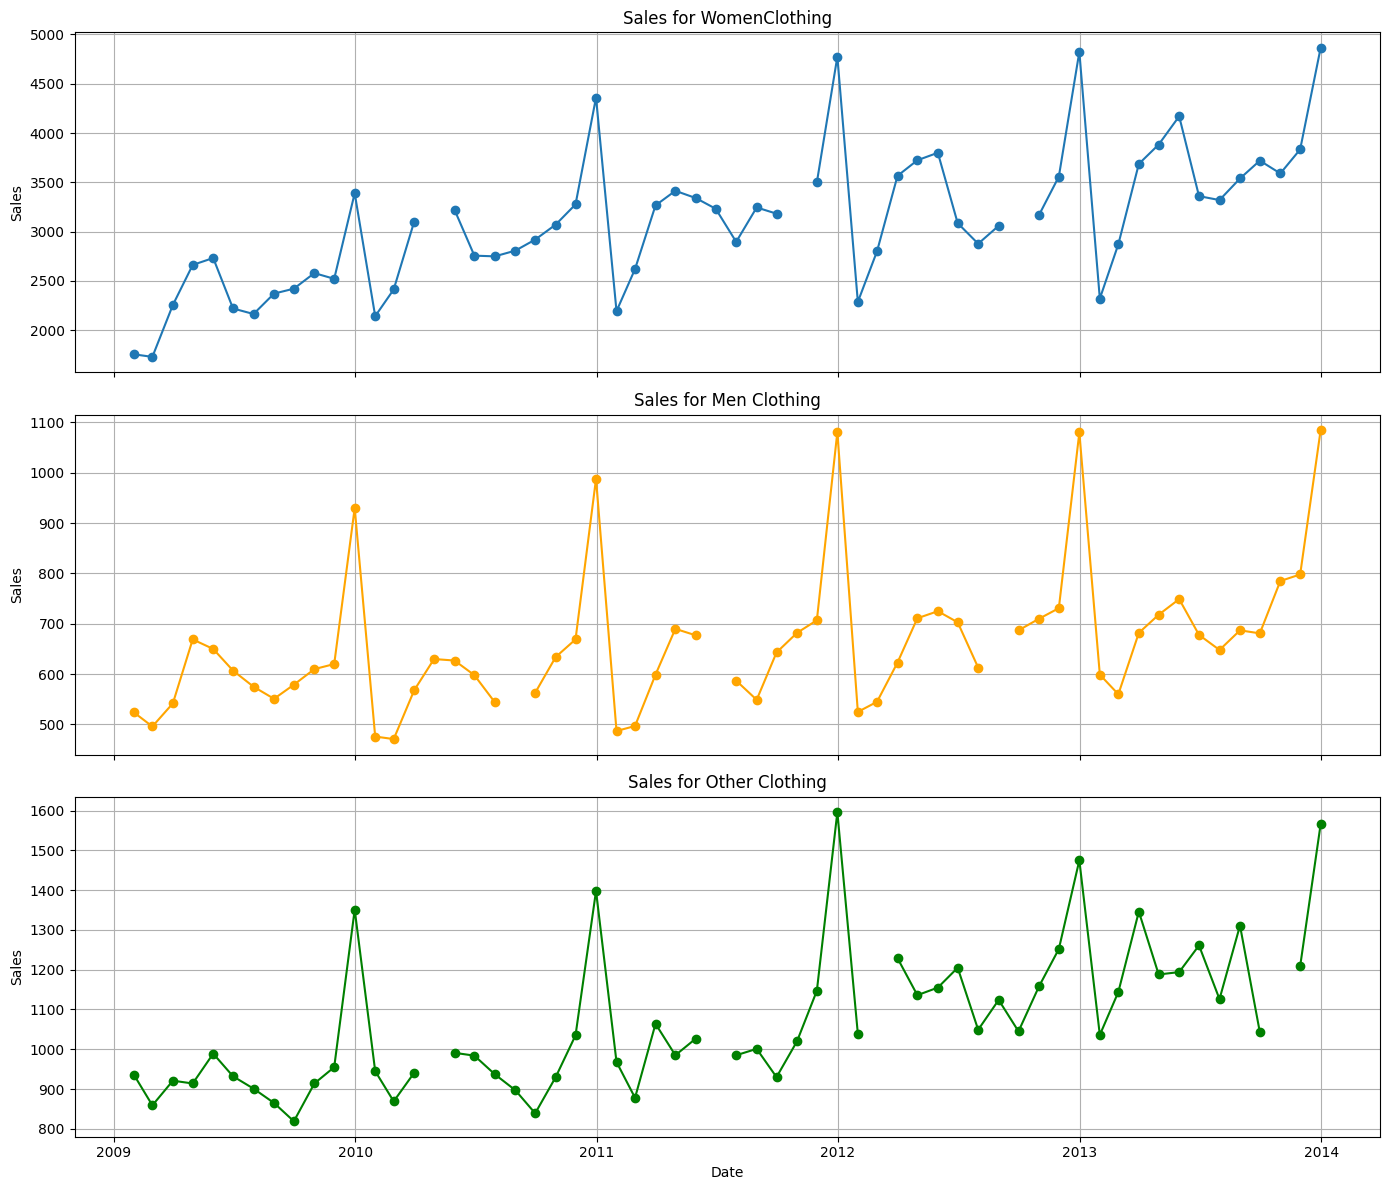

In [7]:
# Split the dataframe by ProductCategory and subset only the 'Sales' and 'Date' columns
df_women = train_arima_df[train_arima_df['ProductCategory'] == 'WomenClothing'][['Date', 'Sales']]
df_men = train_arima_df[train_arima_df['ProductCategory'] == 'MenClothing'][['Date', 'Sales']]
df_other = train_arima_df[train_arima_df['ProductCategory'] == 'OtherClothing'][['Date', 'Sales']]

# Create subplots
fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True)

# Plot each ProductCategory
axes[0].plot(df_women['Date'], df_women['Sales'], marker='o', label='WomenClothing')
axes[0].set_title('Sales for WomenClothing')
axes[0].set_ylabel('Sales')
axes[0].grid(True)

axes[1].plot(df_men['Date'], df_men['Sales'], marker='o', color='orange', label='MenClothing')
axes[1].set_title('Sales for Men Clothing')
axes[1].set_ylabel('Sales')
axes[1].grid(True)

axes[2].plot(df_other['Date'], df_other['Sales'], marker='o', color='green', label='OtherClothing')
axes[2].set_title('Sales for Other Clothing')
axes[2].set_xlabel('Date')
axes[2].set_ylabel('Sales')
axes[2].grid(True)

plt.tight_layout()
plt.show()

We can see that every category has some missing data, will use Interpolation to fill in the missing values

Interpolation: Fill missing values using interpolation, which estimates missing values by assuming a linear relationship between neighboring points.

#### Handling Missing Values

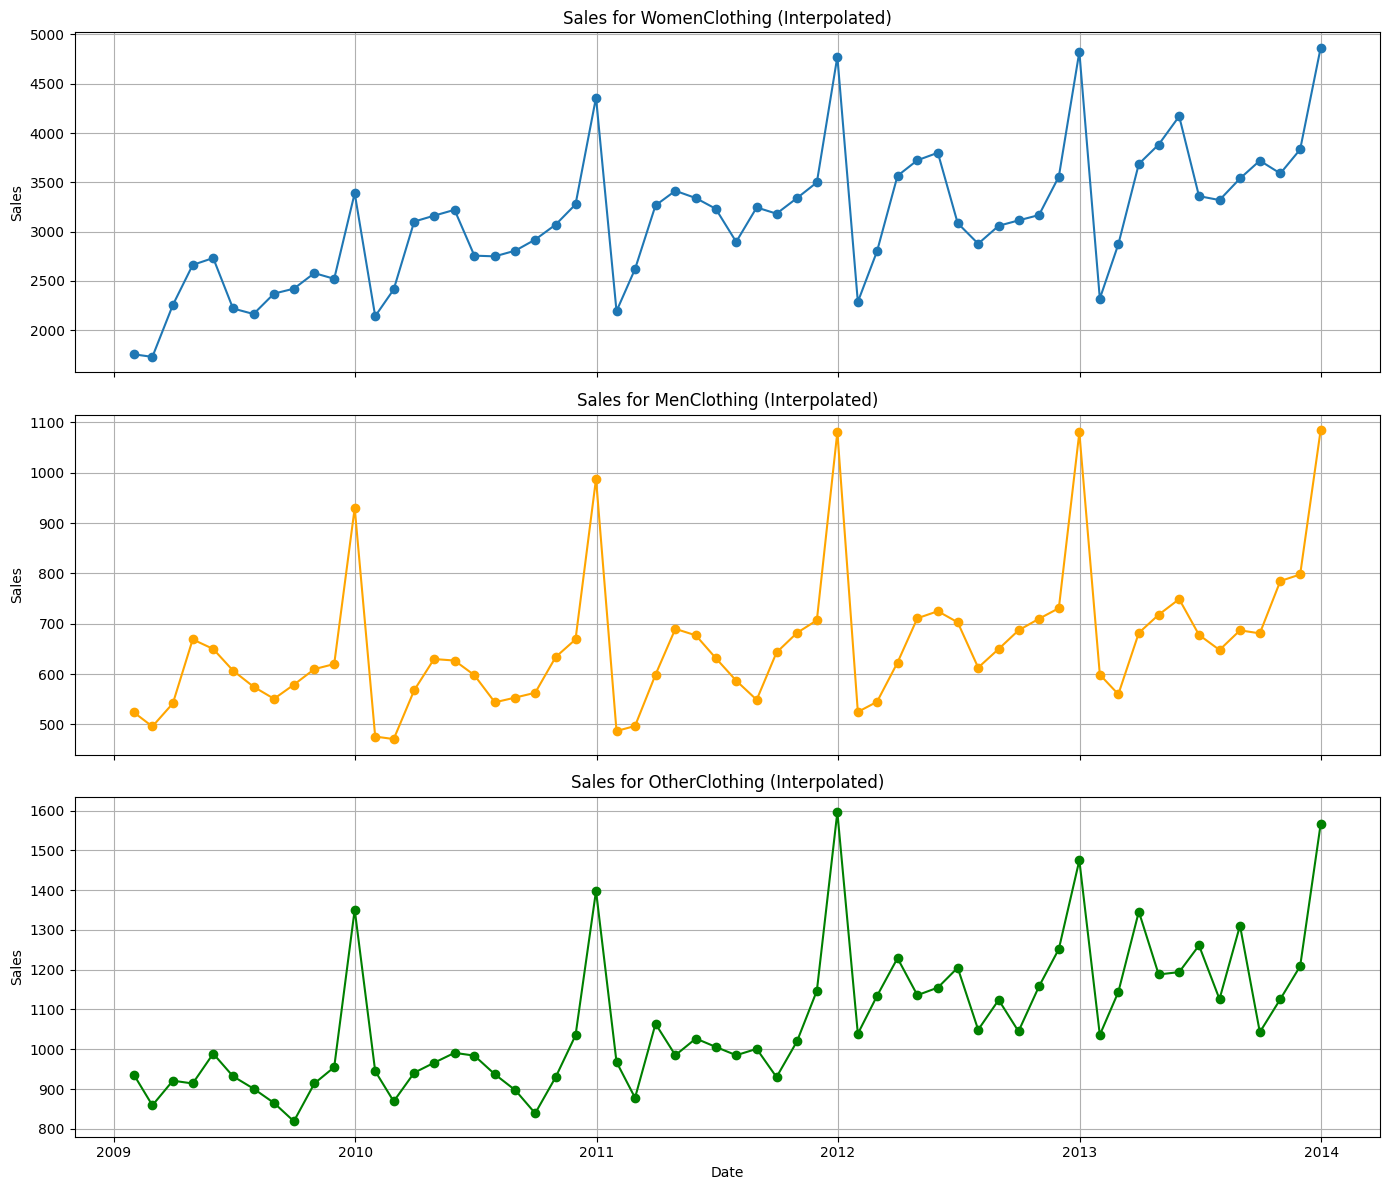

In [8]:
# Create dataframes with interpolation for missing values
df_women_interpolated = df_women.copy()
df_men_interpolated = df_men.copy()
df_other_interpolated = df_other.copy()

df_women_interpolated['Sales'] = df_women_interpolated['Sales'].interpolate()
df_men_interpolated['Sales'] = df_men_interpolated['Sales'].interpolate()
df_other_interpolated['Sales'] = df_other_interpolated['Sales'].interpolate()


# Create subplots for interpolation
fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True)
axes[0].plot(df_women_interpolated['Date'], df_women_interpolated['Sales'], marker='o', label='WomenClothing Interpolated')
axes[0].set_title('Sales for WomenClothing (Interpolated)')
axes[0].set_ylabel('Sales')
axes[0].grid(True)

axes[1].plot(df_men_interpolated['Date'], df_men_interpolated['Sales'], marker='o', color='orange', label='MenClothing Interpolated')
axes[1].set_title('Sales for MenClothing (Interpolated)')
axes[1].set_ylabel('Sales')
axes[1].grid(True)

axes[2].plot(df_other_interpolated['Date'], df_other_interpolated['Sales'], marker='o', color='green', label='OtherClothing Interpolated')
axes[2].set_title('Sales for OtherClothing (Interpolated)')
axes[2].set_xlabel('Date')
axes[2].set_ylabel('Sales')
axes[2].grid(True)

plt.tight_layout()
plt.show()

#### Test for Stationarity

In [9]:
def test_stationarity(df, column, title):
    """
    Perform the Augmented Dickey-Fuller test to check the stationarity of a time series.
    
    Parameters:
    df (pd.DataFrame): DataFrame containing the time series data.
    column (str): The name of the column containing the time series data.
    title (str): The title/name of the DataFrame.
    
    Returns:
    None: Prints the test results along with the DataFrame title.
    """
    print(f'Testing stationarity for {title}...')
    
    # Perform ADF test
    result = adfuller(df[column].dropna())
    
    # Extract and format the results
    adf_statistic = result[0]
    p_value = result[1]
    used_lag = result[2]
    n_obs = result[3]
    critical_values = result[4]
    
    print(f'ADF Statistic: {adf_statistic}')
    print(f'p-value: {p_value}')
    print(f'Number of Lags Used: {used_lag}')
    print(f'Number of Observations Used: {n_obs}')
    print('Critical Values:')
    for key, value in critical_values.items():
        print(f'   {key}: {value}')
    
    # Determine stationarity based on the p-value
    if p_value < 0.05:
        print(f"{title} time series is stationary (reject null hypothesis)")
    else:
        print(f"{title} time series is not stationary (fail to reject null hypothesis)")
    print()


In [10]:
# Perform the ADF test

# Dictionary of DataFrames with titles
dfs = {
    'df_women': df_women_interpolated,
    'df_men': df_men_interpolated,
    'df_other': df_other_interpolated
}

# Loop over DataFrames and test stationarity using tqdm for progress bar
for title, df in tqdm(dfs.items()):
    test_stationarity(df, 'Sales', title)

100%|██████████| 3/3 [00:00<00:00, 495.37it/s]

Testing stationarity for df_women...
ADF Statistic: -2.9426914260877273
p-value: 0.04060404609414759
Number of Lags Used: 11
Number of Observations Used: 48
Critical Values:
   1%: -3.5745892596209488
   5%: -2.9239543084490744
   10%: -2.6000391840277777
df_women time series is stationary (reject null hypothesis)

Testing stationarity for df_men...
ADF Statistic: 1.520129864635399
p-value: 0.997597027617428
Number of Lags Used: 11
Number of Observations Used: 48
Critical Values:
   1%: -3.5745892596209488
   5%: -2.9239543084490744
   10%: -2.6000391840277777
df_men time series is not stationary (fail to reject null hypothesis)

Testing stationarity for df_other...
ADF Statistic: 0.5326892652337949
p-value: 0.9858335146323536
Number of Lags Used: 11
Number of Observations Used: 48
Critical Values:
   1%: -3.5745892596209488
   5%: -2.9239543084490744
   10%: -2.6000391840277777
df_other time series is not stationary (fail to reject null hypothesis)



The only stationary timeseries is the women's. We will need to perform differencing on the other two timeseries, we will also perform differencing on the women's dataset to improve model prediction performance.

In [11]:
# First-order differencing
df_men_interpolated['Sales_diff'] = df_men_interpolated['Sales'].diff()
df_other_interpolated['Sales_diff'] = df_other_interpolated['Sales'].diff()
df_women_interpolated['Sales_diff'] = df_women_interpolated['Sales'].diff()

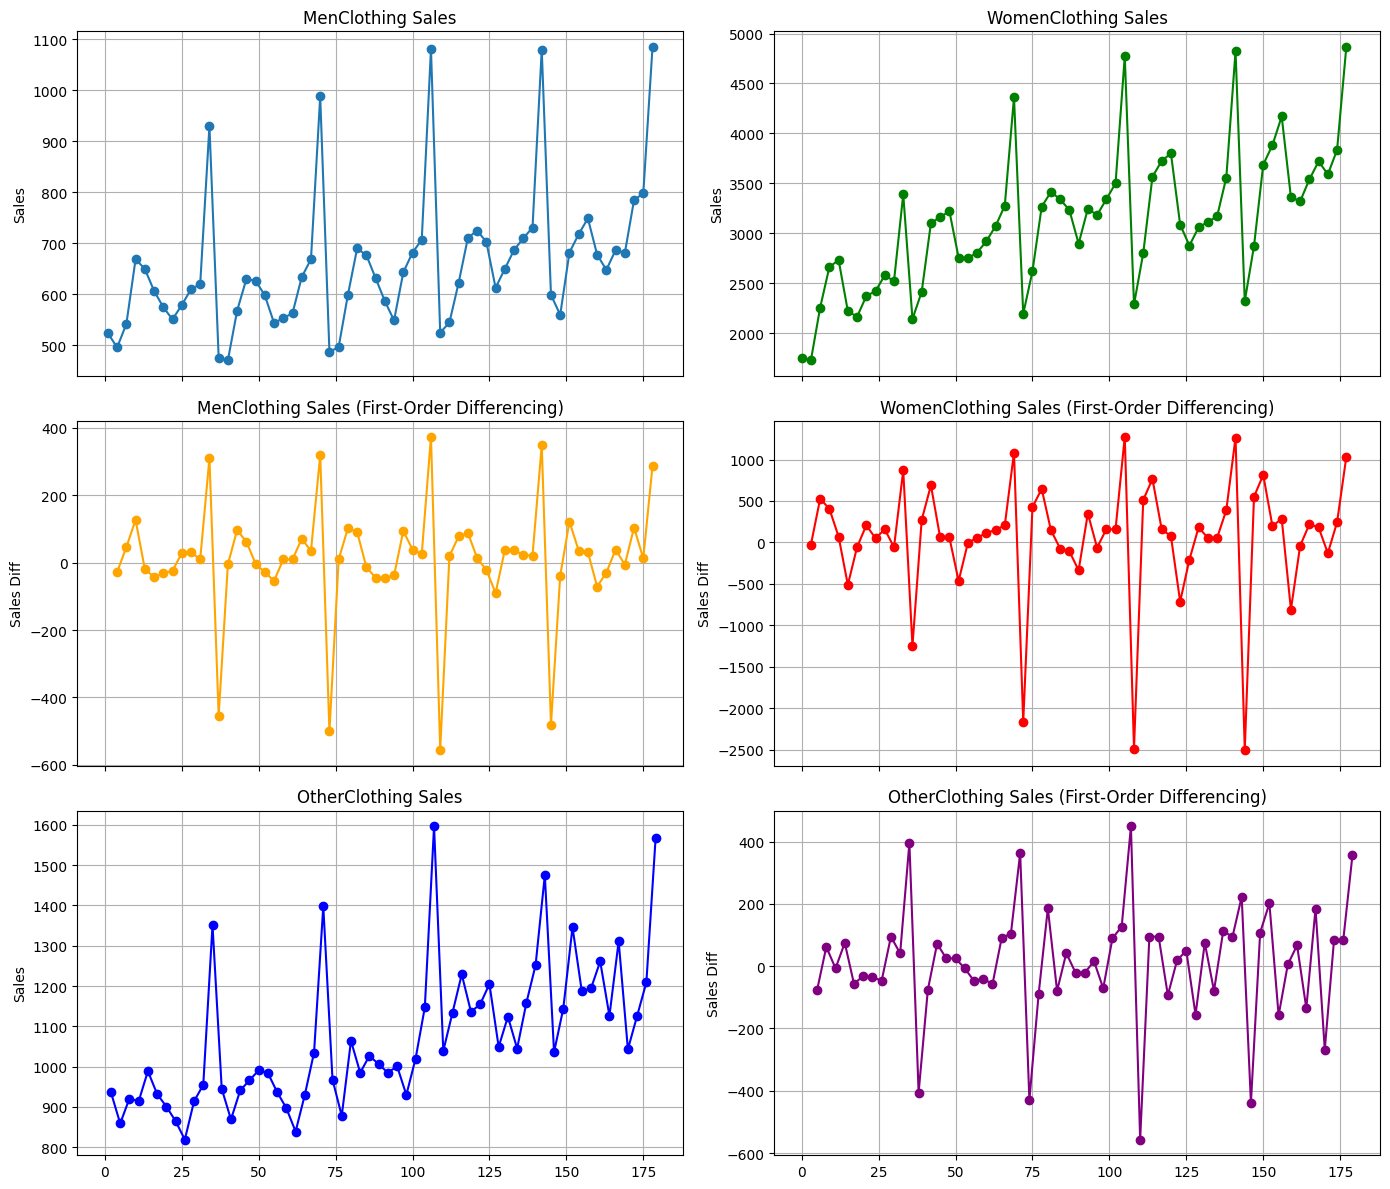

In [12]:
# Create subplots
fig, axes = plt.subplots(3, 2, figsize=(14, 12), sharex=True)

# Plot original and differenced series for df_men_interpolated
axes[0, 0].plot(df_men_interpolated.index, df_men_interpolated['Sales'], marker='o')
axes[0, 0].set_title('MenClothing Sales')
axes[0, 0].set_ylabel('Sales')
axes[0, 0].grid(True)

axes[1, 0].plot(df_men_interpolated.index, df_men_interpolated['Sales_diff'], marker='o', color='orange')
axes[1, 0].set_title('MenClothing Sales (First-Order Differencing)')
axes[1, 0].set_ylabel('Sales Diff')
axes[1, 0].grid(True)

# Plot original and differenced series for df_women_interpolated
axes[0, 1].plot(df_women_interpolated.index, df_women_interpolated['Sales'], marker='o', color='green')
axes[0, 1].set_title('WomenClothing Sales')
axes[0, 1].set_ylabel('Sales')
axes[0, 1].grid(True)

axes[1, 1].plot(df_women_interpolated.index, df_women_interpolated['Sales_diff'], marker='o', color='red')
axes[1, 1].set_title('WomenClothing Sales (First-Order Differencing)')
axes[1, 1].set_ylabel('Sales Diff')
axes[1, 1].grid(True)

# Plot original and differenced series for df_other_interpolated
axes[2, 0].plot(df_other_interpolated.index, df_other_interpolated['Sales'], marker='o', color='blue')
axes[2, 0].set_title('OtherClothing Sales')
axes[2, 0].set_ylabel('Sales')
axes[2, 0].grid(True)

axes[2, 1].plot(df_other_interpolated.index, df_other_interpolated['Sales_diff'], marker='o', color='purple')
axes[2, 1].set_title('OtherClothing Sales (First-Order Differencing)')
axes[2, 1].set_ylabel('Sales Diff')
axes[2, 1].grid(True)

plt.tight_layout()
plt.show()


In [13]:
# Perform the ADF test again

# Dictionary of DataFrames with titles
dfs = {
    'df_men': df_men_interpolated,
    'df_other': df_other_interpolated
}

# Loop over DataFrames and test stationarity using tqdm for progress bar
for title, df in tqdm(dfs.items(), desc='Testing stationarity'):
    test_stationarity(df, 'Sales_diff', title)

Testing stationarity: 100%|██████████| 2/2 [00:00<00:00, 442.79it/s]

Testing stationarity for df_men...
ADF Statistic: -4.483029490388699
p-value: 0.0002110001788536388
Number of Lags Used: 11
Number of Observations Used: 47
Critical Values:
   1%: -3.5778480370438146
   5%: -2.925338105429433
   10%: -2.6007735310095064
df_men time series is stationary (reject null hypothesis)

Testing stationarity for df_other...
ADF Statistic: -3.429110057981133
p-value: 0.01000564670273675
Number of Lags Used: 11
Number of Observations Used: 47
Critical Values:
   1%: -3.5778480370438146
   5%: -2.925338105429433
   10%: -2.6007735310095064
df_other time series is stationary (reject null hypothesis)



All three timeseries are now stationary, we can move forward with training the ARIMA model. **One thing to note is that we will need to invert the differencing to convert the forecasts back to the original scale.**  

### Model Training and Forecasting

In [15]:
# Define training Dataframes

df_men_train = df_men_interpolated[['Date','Sales_diff']].copy().dropna()
df_men_train.rename(columns={'Sales_diff': 'Sales'}, inplace=True)
df_men_train.set_index('Date', inplace=True)
df_other_train = df_other_interpolated[['Date','Sales_diff']].copy().dropna()
df_other_train.rename(columns={'Sales_diff': 'Sales'}, inplace=True)
df_other_train.set_index('Date', inplace=True)
df_women_train = df_women_interpolated[['Date','Sales_diff']].copy().dropna()
df_women_train.set_index('Date', inplace=True)

In [17]:
# Function to fit SARIMA model and make predictions
def fit_sarima_and_forecast(df, column, sarima_order, seasonal_order, title):
    # Split into training and testing sets
    train_size = int(len(df) * 0.8)
    train, test = df.iloc[:train_size], df.iloc[train_size:]
    
    # Fit SARIMA model
    model = SARIMAX(train[column], order=sarima_order, seasonal_order=seasonal_order)
    model_fit = model.fit(disp=False)
    
    # Forecast
    n_forecasts = len(test)
    forecast = model_fit.get_forecast(steps=n_forecasts)
    forecast_index = test.index
    
    # Plot the results
    plt.figure(figsize=(12, 6))
    plt.plot(df[column], label='Original Series')
    plt.plot(forecast_index, forecast.predicted_mean, label='Forecast', color='red')
    plt.axvline(x=train.index[-1], color='gray', linestyle='--', label='Train-Test Split')
    plt.legend()
    plt.title(f'Sales Forecasting for {title} with SARIMA')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.grid(True)
    plt.show()
    
    return model_fit

/Users/qusaifatah/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/Users/qusaifatah/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/Users/qusaifatah/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


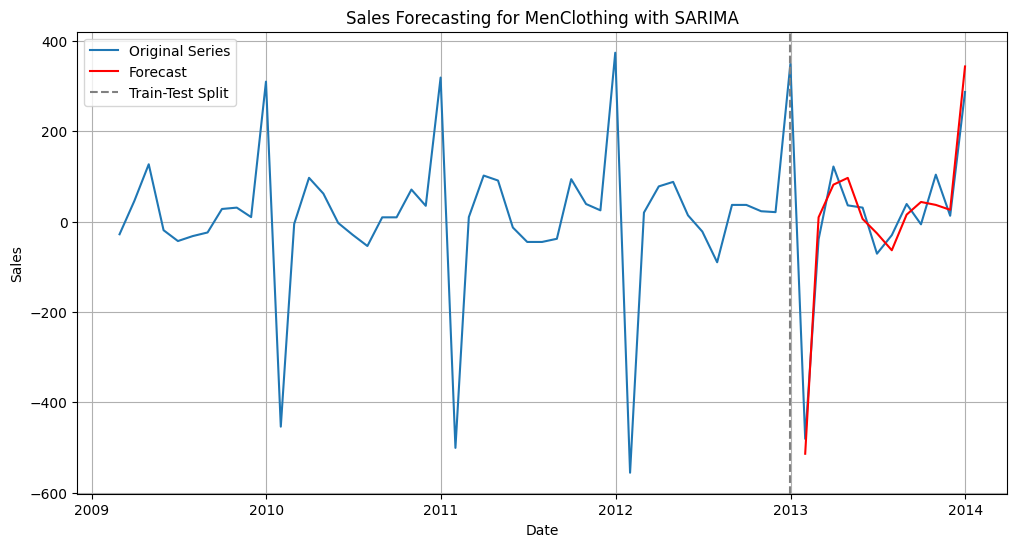

/Users/qusaifatah/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/Users/qusaifatah/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/Users/qusaifatah/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


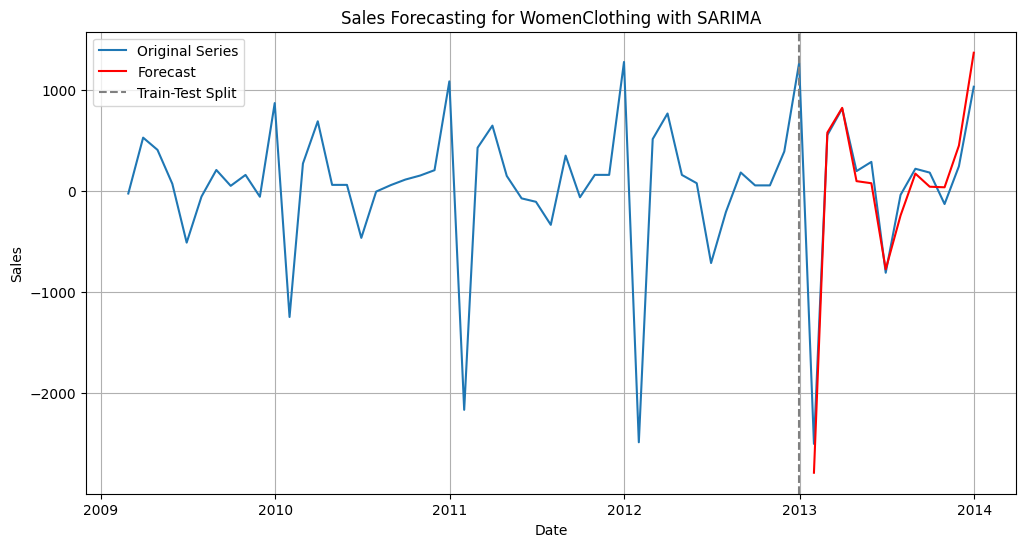

/Users/qusaifatah/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/Users/qusaifatah/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/Users/qusaifatah/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


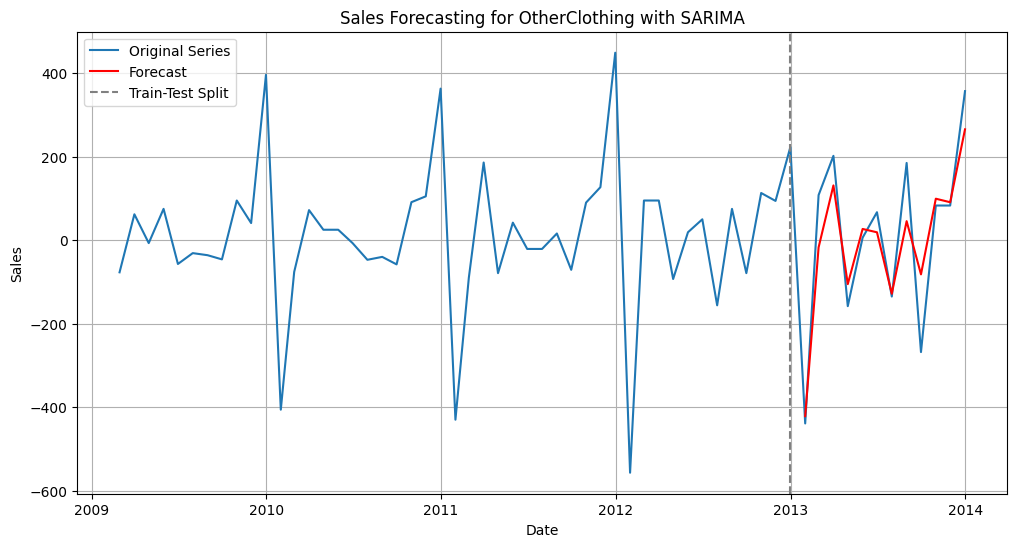

In [18]:
# Assuming df_men_train, df_women_train, and df_other_train are your DataFrames

# Rename columns for consistency
df_men_train = df_men_train.rename(columns={'Sales_diff': 'Sales'})
df_women_train = df_women_train.rename(columns={'Sales_diff': 'Sales'})
df_other_train = df_other_train.rename(columns={'Sales_diff': 'Sales'})

# Fit SARIMA and forecast for each DataFrame
sarima_order = (1, 1, 1)  # Example order, adjust based on your data
seasonal_order = (1, 1, 1, 12)  # Example seasonal order, adjust based on your data

men_model = fit_sarima_and_forecast(df_men_train, 'Sales', sarima_order, seasonal_order, 'MenClothing')
women_model = fit_sarima_and_forecast(df_women_train, 'Sales', sarima_order, seasonal_order, 'WomenClothing')
other_model = fit_sarima_and_forecast(df_other_train, 'Sales', sarima_order, seasonal_order, 'OtherClothing')
